## Custom Gymnasium Enviroment

Import whats needed

In [1]:
import numpy as np
import pandas as pd

In [2]:
# here we convert the jupiter file to a python script since it is easier to handle 
!jupyter nbconvert --to script --output rl_environment rl_environment.ipynb

[NbConvertApp] Converting notebook rl_environment.ipynb to script
[NbConvertApp] Writing 8402 bytes to rl_environment.py


Trading Enviroment Class

In [3]:
import gymnasium as gym         # Gymnasium is a library for building RL environments
                                # It provides a standard interface so RL algorithms (like PPO from Stable Baselines3) can interact with your environment.
from gymnasium import spaces    # spaces defines the action space and observation space for your environment

class TradingEnv(gym.Env):
    def __init__(self, data: pd.DataFrame, window_size=50):
        super().__init__()                              # initialize the base class
        self.data = data.reset_index(drop=True)         # reset index for easier slicing and store it in self.data
        self.window_size = window_size                  # number of previous candles to include in the observation
        self.current_step = window_size                 # start after the initial window

        # Observation: last N candles (OHLC + Volume)
        self.observation_space = spaces.Box(            # description of the observation space is given
            low=-np.inf, high=np.inf,                   # low and high values for each element in the observation are unbounded / infinite
            shape=(window_size, self.data.shape[1]),    # shape of the observation (window_size rows, number of features columns)
            dtype=np.float32                            # data type of the observation elements
        )
        # Actions: 0 = Hold, 1 = Buy, 2 = Sell
        self.action_space = spaces.Discrete(3)          # actually, there is not much we can do

    def reset(self, seed=None, options=None):           # reset the environment to initial state
        super().reset(seed=seed)                        # call the base class reset method
        self.current_step = self.window_size            # bring current step back to initial position
        return self._get_observation(), {}              # return the last known observation and an empty info dict
                                                        #   -> dict can be used to pass additional information like debugging info                                               

    def step(self, action):                             # do one step of the training
        reward = self._calculate_reward(action)         # calculate reward based on action taken - in the end the |profit/loss|
        self.current_step += 1                          # move to the next time step
        done = self.current_step >= len(self.data) - 1  # episode is done if we reach the end of the data
        return self._get_observation(), reward, done, False, {} 

    def _get_observation(self):
        obs = self.data.iloc[self.current_step - self.window_size:self.current_step].values # Return last N rows as observation ":" is NOT a division
        return obs.astype(np.float32)                   # return the last <windwow_size> observations as float32 numpy array

    def _calculate_reward(self, action):                # the REWARD is calculated based on the difference in closing prices
        if self.current_step + 1 >= len(self.data):     # check if we are at the end of the data
            print("End of data reached - we should never get here")
            return 0.0
        price_diff = self.data['Close'].iloc[self.current_step + 1] - self.data['Close'].iloc[self.current_step]
        if action == 1:   # BUY <-----------------------
            return price_diff
        elif action == 2: # SELL <----------------------
            return -price_diff
        else:             # HOLD <----------------------
            return 0.0

    
    def render(self, action=None, reward=None):  # render the current state of the environment
        msg = f"Step: {self.current_step}, Close Price: {self.data['Close'].iloc[self.current_step]}"
        if action is not None:  # if an action was taken, include it in the message
            msg += f", Action: {action}"
        if reward is not None:  # if a reward was given, include it in the message
            msg += f", Reward: {reward:.4f}"
        print(msg)



Get the data and normalize it with Z-score

In [4]:
# since StandardSkaler works column-wise, and OHLC value should have the SAME scaling, we have to do a bit of manual work here
class OHLCScaler:
    def __init__(self, train_df: pd.DataFrame):                     # with the init fct the hole dataset is given in for Open, High, Low, Close and Volume
        self.columns_ohlc = ['Open', 'High', 'Low', 'Close']        # all OHLC columns in one mean/std
        self.column_volume = 'Volume'                               # Volume column in a 2nd mean/std

        ohlc_values = train_df[self.columns_ohlc].values.flatten()  # get all given OHLC values from all columns 
        self.mean_ohlc = np.mean(ohlc_values)                       # calculate mean for OHLC values
        self.std_ohlc = np.std(ohlc_values)                         # calculate std for OHLC values

        volume_values = train_df[self.column_volume].values         # same for all Volume values
        self.mean_volume = np.mean(volume_values)
        self.std_volume = np.std(volume_values)

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:      # the transform method scales a hole given dataframe in the form Open, High, Low, Close and Volume
        df_scaled = df.copy()
        for col in self.columns_ohlc:
            df_scaled[col]            = (df_scaled[col]                - self.mean_ohlc)   / self.std_ohlc
        df_scaled[self.column_volume] = (df_scaled[self.column_volume] - self.mean_volume) / self.std_volume
        return df_scaled
    
    def re_transform(self, normalized_gain: float, normalized_price: float) -> tuple:
        real_price = normalized_price * self.std_ohlc + self.mean_ohlc
        real_gain  = normalized_gain  * self.std_ohlc # for the gain the mean μ is not needed -> −μ−(−μ)=−μ+μ=0
        return real_gain, real_price


In [24]:
import joblib

# Load raw data
data = pd.read_csv('../data/Candlestick_01jan2000_31dec2024.csv', parse_dates=['date'], index_col='date')

# Split into train/test
split_idx  = int(len(data) * 0.8)
train_data = data.iloc[:split_idx]
test_data  = data.iloc[split_idx:]

# Fit OHLCScaler on training data
scaler = OHLCScaler(train_data)

# Transform train and test data
scaled_train_df = scaler.transform(train_data)
scaled_test_df  = scaler.transform(test_data)

# Save scaler for future use
joblib.dump(scaler, '../models/scaler.pkl')

['../models/scaler.pkl']

Understand the Data better

In [6]:
# let's have a look at the original data
print(data.head()) # print the first few rows of the original data
print("...")
print(data.tail())  # print the last few rows of the original data

              Open    High    Low  Close     Volume
date                                               
2000-01-03  116.03  116.03  113.0  113.5  1278800.0
2000-01-04  112.30  113.00  109.8  109.8  1535700.0
2000-01-05  110.00  112.00  109.0  111.8  2007000.0
2000-01-06  111.40  113.20  111.2  111.8  2639500.0
2000-01-07  113.30  115.60  113.2  115.5  3767400.0
...
              Open      High      Low   Close     Volume
date                                                    
2024-12-24  428.89  432.6300  428.280  432.50  1431692.0
2024-12-26  430.97  433.6700  430.920  433.21  1869575.0
2024-12-27  430.58  432.2900  427.430  430.00  2429126.0
2024-12-30  425.47  427.6600  422.520  425.77  3858271.0
2024-12-31  426.91  427.7399  424.035  425.50  2442722.0


In [7]:
# let's have a look at the scaled training data
print(scaled_train_df.head()) # print the first few rows of the scaled training data
print("...")
print(scaled_test_df.tail())  # print the last few rows of the scaled test data

                Open      High       Low     Close    Volume
date                                                        
2000-01-03 -0.468708 -0.468708 -0.527051 -0.517424 -0.893814
2000-01-04 -0.540530 -0.527051 -0.588669 -0.588669 -0.857961
2000-01-05 -0.584817 -0.546307 -0.604073 -0.550158 -0.792187
2000-01-06 -0.557860 -0.523200 -0.561711 -0.550158 -0.703916
2000-01-07 -0.521275 -0.476987 -0.523200 -0.478913 -0.546508
...
                Open      High       Low     Close    Volume
date                                                        
2024-12-24  5.555530  5.627545  5.543784  5.625042 -0.872476
2024-12-26  5.595581  5.647571  5.594618  5.638713 -0.811366
2024-12-27  5.588071  5.620998  5.527417  5.576903 -0.733276
2024-12-30  5.489676  5.531846  5.432873  5.495453 -0.533827
2024-12-31  5.517404  5.533384  5.462045  5.490254 -0.731378


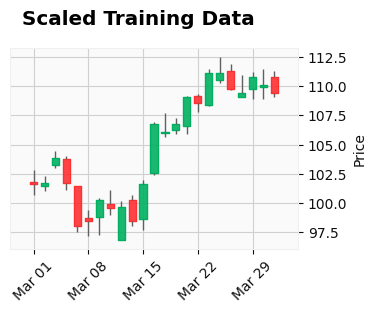

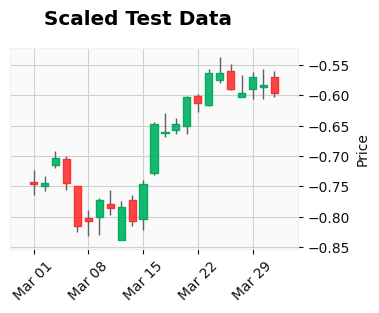

In [23]:
# view both datasets as candle-stick charts, lets say one month each
import matplotlib.pyplot as plt
import mplfinance as mpf

FIG_SCALE = 0.5

plot_data_org = data.loc['2000-03-01':'2000-03-31']
plot_data_nor = scaled_train_df.loc['2000-03-01':'2000-03-31']

mpf.plot(plot_data_org, type='candle', volume=False, title='Scaled Training Data', style='yahoo', figscale=FIG_SCALE)
mpf.plot(plot_data_nor, type='candle', volume=False, title='Scaled Test Data', style='yahoo', figscale=FIG_SCALE)

PPO training and evaluation code

In [8]:
from stable_baselines3 import PPO

# Create environment
env = TradingEnv(scaled_train_df, window_size=50)

# Train PPO agent
model = PPO("MlpPolicy", env, verbose=1)    # create PPO (Proximal Policy Optimization) model with MLP policy
model.learn(total_timesteps=100_000)        # train the model for 100,000 timesteps

model.save("../models/ppo_trading")         # save the trained model (the model is now trained until the NOW)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1858 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1339        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008923888 |
|    clip_fraction        | 0.0488      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.405       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0147     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0107     |
|    value_loss         

Now let's test the mode

In [13]:

# Test-Umgebung erstellen
test_env = TradingEnv(scaled_test_df, window_size=50)

# Evaluation
obs, info = test_env.reset()                    # reset the environment to start a new episode
total_reward = 0                                # initialize total reward
steps = 0                                       # initialize step counter

while True:
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = test_env.step(action)
    total_reward += reward
    steps += 1
    if done:
        break

print(f"Total Reward on Test Data: {total_reward:.4f}")
print(f"Steps: {steps}")

Total Reward on Test Data: -0.8376
Steps: 1207
